In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_path = "/notebooks/climate.csv"
df = pd.read_csv(data_path)
df = df.drop('Date Time', axis=1)

train_data, valid_data = train_test_split(df, test_size=0.3, shuffle=False)

print(train_data.shape)
print(valid_data.shape)

(294315, 14)
(126136, 14)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=df.columns)
valid_data = pd.DataFrame(scaler.transform(valid_data), columns=df.columns)


In [13]:
sequence_length = 720  # e.g., use the past 5 days of data
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data.values[:-1],  # Exclude the last value since it won't have a corresponding target
    targets=train_data['T (degC)'].values[1:],  # Shifted by one to align with the sequences
    sequence_length=sequence_length,
    sequence_stride=1,
    shuffle=True,
    batch_size=batch_size
)

valid_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=valid_data.values[:-1],  # Exclude the last value since it won't have a corresponding target
    targets=valid_data['T (degC)'].values[1:],  # Shifted by one to align with the sequences
    sequence_length=sequence_length,
    sequence_stride=1,
    shuffle=False,
    batch_size=batch_size
)


In [22]:
'''
There are specific conditions that must be met for the LSTM layer to leverage cuDNN in TensorFlow:

1. Activation Function: The activation must be tanh.
2. Recurrent Activation Function: The recurrent activation must be sigmoid.
3. Return Sequences: Both the input and output of the LSTM layer must have the same format 
(either both sequences or both individual values). This is controlled by the return_sequences argument.
4. No Dropout: You cannot use dropout or recurrent dropout within the LSTM layer.
'''

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

for x_batch, y_batch in train_dataset.take(1):
    input_shape = x_batch.shape[1:]

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape, activation='tanh', recurrent_activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, activation='tanh', recurrent_activation='sigmoid'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

print(input_shape)


(720, 14)


In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(train_dataset, epochs=100, batch_size=256, validation_data=valid_dataset, 
                    callbacks=[early_stop, checkpoint])


Epoch 1/100
1147/1147 [==============================] - 80s 68ms/step - loss: 0.4376 - val_loss: 0.4249
Epoch 2/100
1147/1147 [==============================] - 77s 67ms/step - loss: 0.4103 - val_loss: 0.4052
Epoch 3/100
1147/1147 [==============================] - 76s 66ms/step - loss: 0.1565 - val_loss: 0.0260
Epoch 4/100
1147/1147 [==============================] - 78s 68ms/step - loss: 0.0324 - val_loss: 0.0175
Epoch 5/100
1147/1147 [==============================] - 76s 66ms/step - loss: 0.0268 - val_loss: 0.0127
Epoch 6/100
1147/1147 [==============================] - 75s 66ms/step - loss: 0.0235 - val_loss: 0.0116
Epoch 7/100
1147/1147 [==============================] - 76s 66ms/step - loss: 0.0215 - val_loss: 0.0136
Epoch 8/100
1147/1147 [==============================] - 74s 65ms/step - loss: 0.0199 - val_loss: 0.0105
Epoch 9/100
1147/1147 [==============================] - 77s 67ms/step - loss: 0.0185 - val_loss: 0.0143
Epoch 10/100
1147/1147 [==============================]

KeyError: 'mae'

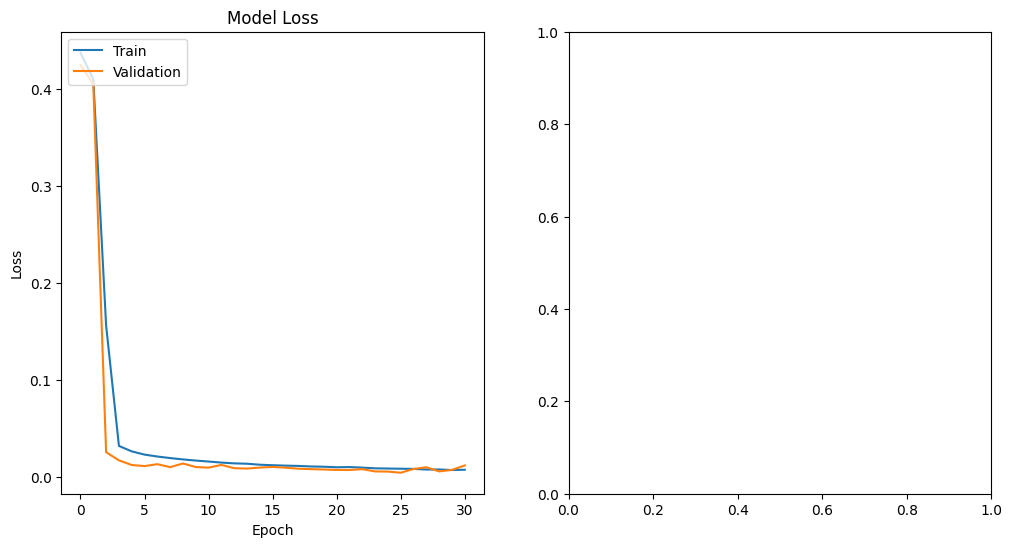

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# If accuracy is one of the metrics you're monitoring:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])  # or 'mae' or any other metric you're tracking
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [27]:
test_loss = model.evaluate(valid_dataset)
print(f"Test Loss: {test_loss}")


490/490 [==============================] - 13s 27ms/step - loss: 0.0123
Test Loss: 0.012278293259441853


490/490 [==============================] - 13s 26ms/step


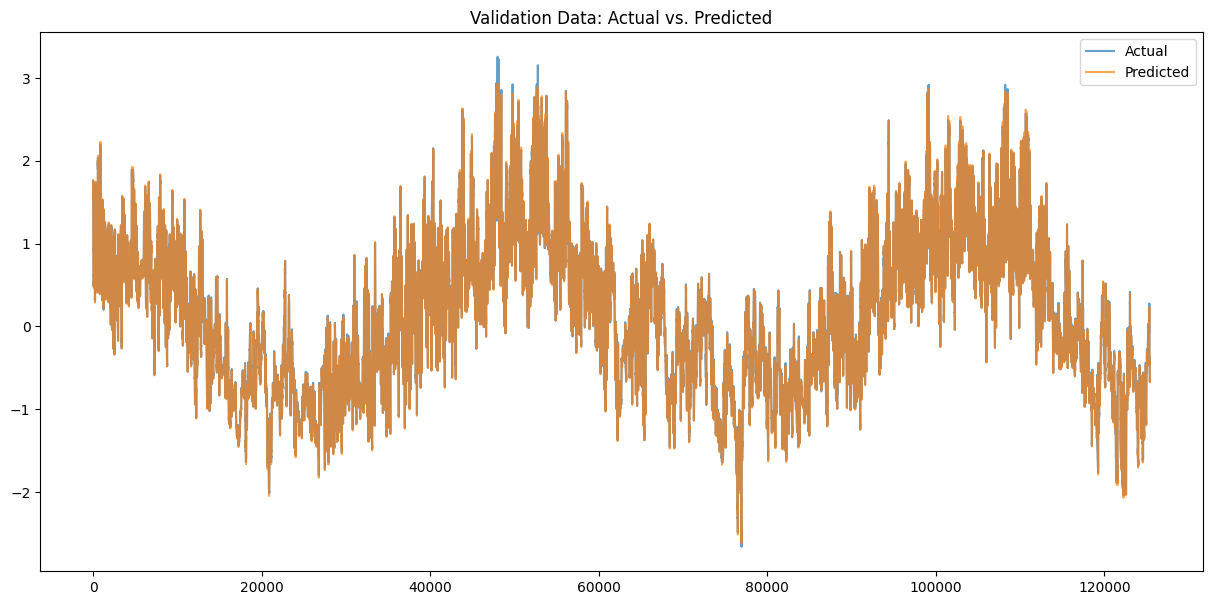

In [30]:
# Assuming test_data and test_targets for simplicity; adapt as needed for your setup
predictions = model.predict(valid_dataset)
# Extracting actual targets from valid_dataset
actual_targets = []
for _, y_batch in valid_dataset:
    actual_targets.extend(y_batch.numpy())
actual_targets = np.array(actual_targets)

plt.figure(figsize=(15, 7))
plt.plot(actual_targets, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Validation Data: Actual vs. Predicted')
plt.legend()
plt.show()



In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

val_predictions = model.predict(valid_dataset)

# Extracting actual targets from valid_dataset
actual_targets = []
for _, y_batch in valid_dataset:
    actual_targets.extend(y_batch.numpy())
actual_targets = np.array(actual_targets)

mse = mean_squared_error(actual_targets, val_predictions)
mae = mean_absolute_error(actual_targets, val_predictions)

print(f"Mean Squared Error on Validation Data: {mse}")
print(f"Mean Absolute Error on Validation Data: {mae}")



490/490 [==============================] - 13s 26ms/step
Mean Squared Error on Validation Data: 0.0002490986937310891
Mean Absolute Error on Validation Data: 0.01227829905758261
